In [1]:
import numpy

In [2]:
%load_ext autoreload
%autoreload 2 

In [3]:
import sys
sys.path.append('../src')

from dataset import Tell1Dataset, DatasetTree
import dataset as DS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()
import matplotlib
matplotlib.rcParams['image.cmap'] = 'rainbow'

Loading BokehJS ...

Read dataset:

In [7]:
dataset = Tell1Dataset(r'../../data/calibrations')

In [8]:
def sensor_histogram(data):
    x_data_list = []
    y_data_list = []
    for i,column in enumerate(data):
        y_data = list(data[column].values)
        y_data_list += y_data
        x_data_list += [i]*len(y_data)
    return x_data_list, y_data_list

# Thresholds

Thresholds are used to determine the hit in detector. They are calculated by measuring the standard deviation of signal in channel. High threshold is 6 sigma and low i s 2 sigma (or smth), so 

The plot below represents the high threshold value in **all calibrations** for **all sensors**, both R-type and Phi-type.

In [10]:
data = dataset.dfh.df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30])
axe.set_title('All module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Text(0, 0.5, 'ADC')

There are some values that are bumping the scope of the histogram. lets zoom to the bottom part

Text(0, 0.5, 'ADC')

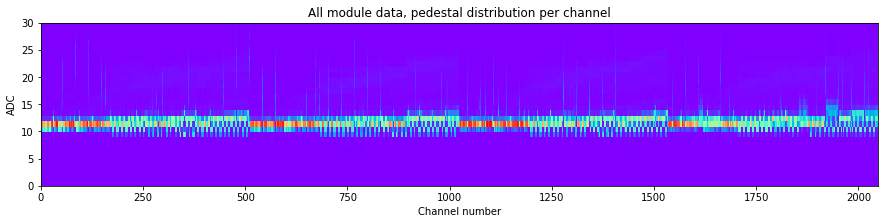

In [11]:
data = dataset.dfh.df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[0,30]])
axe.set_title('All module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

we can see that adc oscillates somewhat around value of 10-12. Those data are to general, we need to separate R type sensor and phi type

### R-type

In [12]:
data = dataset.dfh['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[0,30]])
axe.set_title('R-type module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Text(0, 0.5, 'ADC')

### Phi - type

Text(0, 0.5, 'ADC')

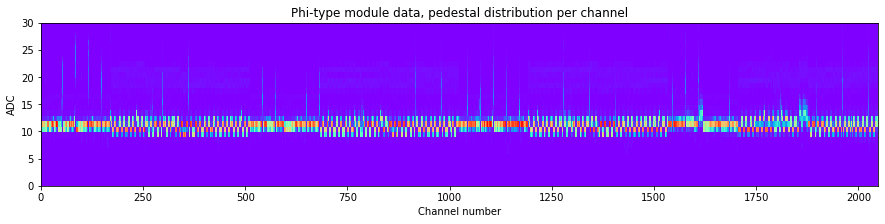

In [13]:
data = dataset.dfh['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[0,30]])
axe.set_title('Phi-type module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

In both cases we can see that values oscillate around 10, but faint 'ghost-distribution' is visible.

## R-type, ghosting

To determine whats causing this ghosting, lets just inspect entries with values greater than 15.0

In [14]:
dfhr = dataset.dfh['R'].df
increased = dfhr.iloc[:,9:]>15.0

Lets check the sum of entriex exceeding 15 per sensor calibration

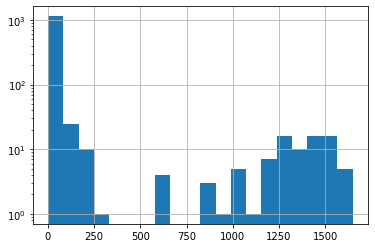

In [15]:
increased.sum(axis=1).hist(bins=20, log=True)

We can see that there are outliers with more than 400 entries that exceed that value, lets separate those entries.

In [16]:
high_values = dfhr[increased.sum(axis=1)>400]

And see at what dates did they occur

In [17]:
bad_calibration = high_values['datetime'].unique()
bad_calibration

array(['2012-07-30T00:00:00.000000000', '2012-08-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

Those are the dates that correspond with callibration process errors.

lets look at the distributions per channel again, after excluding those dates

In [19]:
wrong = dataset.dfh.df[dataset.dfh.df['datetime'].isin(bad_calibration)]
other = dataset.dfh.df[~dataset.dfh.df['datetime'].isin(bad_calibration)]
wrong = DS.DatasetTree.from_df(wrong)
other = DS.DatasetTree.from_df(other)

#### R-type sensors for High threshold

Wrong

In [79]:
data = wrong['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(20,5))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[0,30]])

Good

In [80]:
data = other['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(20,5))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[0,30]])

#### Phi-type for High threshold:

worng

In [81]:
data = wrong['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(20,5))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[0,30]])

good

In [82]:
data = other['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(20,5))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[0,30]])

## Important !!
 - We see some faint peculiar distribution in some channels, in both good calibrations and bad
 - still, there are some high values, that are outside the scope of the plotsabove 

# Wild things and vampires

In [20]:
filtered = (other.df.iloc[:,9:]>=50) & (other.df.iloc[:,9:]!=127.0)
outliers = other.df.iloc[:,9:][filtered]

In [21]:
occurance_per_row = filtered.sum(axis=1)

In [22]:
chart1_df = other.df.drop(other.df.iloc[:,9:].columns , axis=1)

In [23]:
chart1_df['occurances'] = occurance_per_row

Text(0, 0.5, '# of occurances')

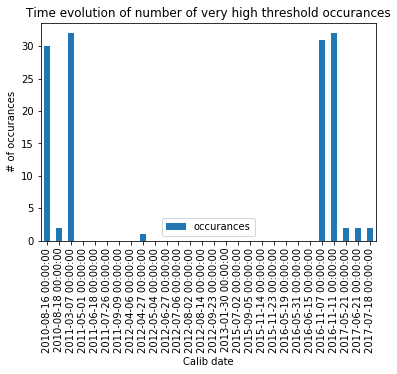

In [24]:
axe = chart1_df.groupby(['datetime']).sum().plot(y='occurances',kind='bar')
axe.set_title('Time evolution of number of very high threshold occurances')
axe.set_xlabel('Calib date')
axe.set_ylabel('# of occurances')

In [25]:
chart2_df = chart1_df[chart1_df.occurances != 0]

In [26]:
x = chart2_df.datetime
labels = chart2_df['sensor_number'].unique()
todf = {k:[] for k in labels}
yx = []
for date in x:
    for label in labels:
        data_ = chart2_df[chart2_df.datetime==date]
        val = data_[data_.sensor_number==label].occurances.values
        if not val:
            val = 0
        else:
            val = val[0]
        todf[label].append(val)
occurances_df = pd.DataFrame(todf,index=x.values)
occurances_df = occurances_df.sort_index()

/home/mwm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


In [27]:
occurances_df

#67  #85  #94
2010-08-16    0   30    0
2010-08-18    0    2    0
2011-03-07    0   32    0
2012-04-27    1    0    0
2016-11-07   31    0    0
2016-11-11   32    0    0
2017-05-21    0    0    2
2017-06-21    0    0    2
2017-07-18    0    0    2

In [28]:
occurances_df.to_csv()

',#67,#85,#94\n2010-08-16,0,30,0\n2010-08-18,0,2,0\n2011-03-07,0,32,0\n2012-04-27,1,0,0\n2016-11-07,31,0,0\n2016-11-11,32,0,0\n2017-05-21,0,0,2\n2017-06-21,0,0,2\n2017-07-18,0,0,2\n'

Text(0, 0.5, 'Occurances in sensor')

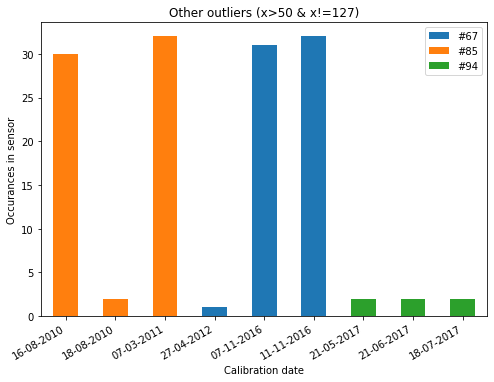

In [32]:
fig, axe = plt.subplots(1,1,figsize=(8,6))
occurances_df.plot(kind='bar', ax=axe,align="center", stacked=True)
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(occurances_df.index.to_series().dt.strftime("%d-%m-%Y")))
fig.autofmt_xdate()
axe.set_title("Other outliers (x>50 & x!=127)")
axe.set_xlabel('Calibration date')
axe.set_ylabel('Occurances in sensor')

In [94]:
chart1_df.groupby(['datetime']).sum()

Zmod  occurances
datetime                     
2010-08-16  16130          30
2010-08-18  16130           2
2011-03-07  16130          32
2011-05-01  16130           0
2011-06-18  16130           0
2011-07-26  16130           0
2011-09-09  16130           0
2012-04-06  16130           0
2012-04-27  16130           1
2012-05-04  16130           0
2012-06-27  16130           0
2012-07-06  16130           0
2012-08-02  16130           0
2012-08-14  16130           0
2012-09-23  16130           0
2013-01-30  16130           0
2015-07-02  16130           0
2015-09-05  16130           0
2015-11-14  16130           0
2015-11-23  16130           0
2016-05-19  16130           0
2016-05-31  16130           0
2016-06-15  16130           0
2016-11-07  16130          31
2016-11-11  16130          32
2017-05-21  16130           2
2017-06-21  16130           2
2017-07-18  16130           2

In [95]:
axe = chart1_df.groupby(['sensor_number']).sum().plot(y='occurances')
axe.set_title('Occurances of very high threshold per sensor')
axe.set_xlabel('Sensor')
axe.set_ylabel('# of occurances')

Text(0,0.5,'# of occurances')

In [96]:
persensor = chart1_df.groupby(['sensor_number']).sum()

In [97]:
persensor[persensor['occurances']!=0]

Zmod  occurances
sensor_number                  
#67           -3640          64
#85            3920          64
#94            7700           6

In [98]:
data = other[occurance_per_row!=0].iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(20,5))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[50,500]])
axe.set_title('Phi-type sensor callibrations where value >=50 and value != 127')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Text(0,0.5,'ADC')

In [99]:
data = other[occurance_per_row!=0].iloc[:,9:]
data 

channel0  channel1  channel2  channel3  channel4  channel5  channel6  \
4076      13.0      11.0      11.0      11.0      11.0      11.0      12.0   
4127      12.0      11.0      11.0      11.0      11.0      11.0      11.0   
4130      12.0      12.0      11.0      11.0      11.0      11.0      11.0   
5672      11.0      11.0      11.0      11.0      10.0      10.0      11.0   
5675      11.0      11.0      11.0      10.0      10.0      10.0      10.0   
5678      11.0      11.0      11.0      11.0      11.0      11.0      11.0   
6563      10.0      11.0      10.0      11.0      11.0      11.0      11.0   
6566      11.0      11.0      11.0      10.0      10.0      11.0      10.0   
6569      10.0      11.0      10.0      11.0      10.0      10.0      11.0   

      channel7  channel8  channel9     ...       channel2038  channel2039  \
4076      11.0      11.0      12.0     ...               9.0         11.0   
4127      11.0      11.0      11.0     ...              10.0         12.0   
4130      11.0      11.0      11.0     ...              10.0         12.0   
5672      11.0      10.0      10.0     ...              10.0         11.0   
5675      10.0      10.0      10.0     ...              10.0         11.0   
5678      11.0      11.0      11.0     ...              10.0         11.0   
6563      11.0      11.0      11.0     ...               9.0         11.0   
6566      10.0      10.0      10.0     ...               9.0         11.0   
6569      11.0      11.0      11.0     ...               9.0         12.0   

      channel2040  channel2041  channel2042  channel2043  channel2044  \
4076          9.0         12.0         10.0         12.0          9.0   
4127         10.0         12.0         10.0         12.0         10.0   
4130         10.0         12.0         10.0         12.0         10.0   
5672         10.0         12.0         10.0         11.0         10.0   
5675         10.0         11.0         10.0         11.0         11.0   
5678          9.0         11.0         10.0         12.0         10.0   
6563          9.0         11.0          9.0         11.0         10.0   
6566         10.0         12.0          9.0         11.0          9.0   
6569         10.0         12.0          9.0         11.0          9.0   

      channel2045  channel2046  channel2047  
4076          6.0         10.0         13.0  
4127          7.0         11.0         12.0  
4130          7.0         11.0         12.0  
5672         11.0         10.0         11.0  
5675         11.0         10.0         12.0  
5678         11.0         10.0         12.0  
6563         11.0         10.0         12.0  
6566         11.0          9.0         11.0  
6569         11.0          9.0         11.0  

[9 rows x 2048 columns]

In [100]:
data = other["#94"][occurance_per_row!=0].iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(20,5))
_ = plt.hist2d(px, py, bins=[2048,30])

../src\dataset.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.df[item]


In [101]:
data = other["#67"][occurance_per_row!=0].iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(20,5))
_ = plt.hist2d(px, py, bins=[2048,30])

../src\dataset.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.df[item]


../src\dataset.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.df[item]


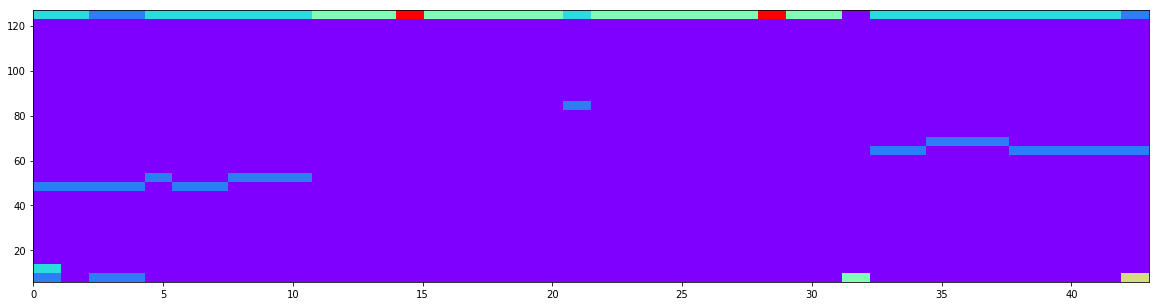

In [102]:
data = other["#85"][occurance_per_row!=0].iloc[:,1032:1076]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(20,5))
_ = plt.hist2d(px, py, bins=[40,30])

../src\dataset.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.df[item]


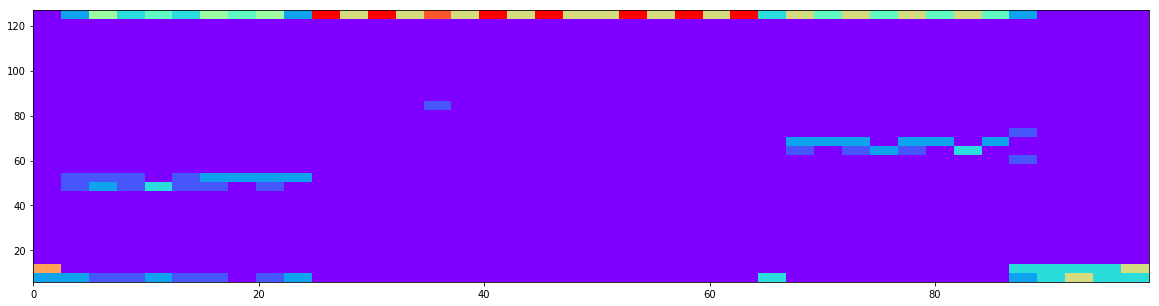

In [103]:
data = other["#85"][occurance_per_row!=0].iloc[:,1200:1300]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(20,5))
_ = plt.hist2d(px, py, bins=[40,30])

In [104]:
other["#85"][occurance_per_row!=0][["datetime","sensor_type"]]

../src\dataset.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.df[item]


datetime sensor_type
5672 2010-08-16         phi
5675 2010-08-18         phi
5678 2011-03-07         phi

../src\dataset.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.df[item]


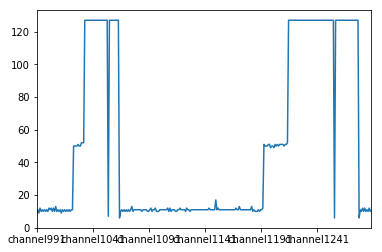

In [105]:
other["#85"][occurance_per_row!=0].iloc[0,1000:1300].plot()

In [106]:
other["#94"][occurance_per_row!=0][["datetime","sensor_type"]]

../src\dataset.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.df[item]


datetime sensor_type
6563 2017-05-21         phi
6566 2017-06-21         phi
6569 2017-07-18         phi

In [107]:
other["#67"][occurance_per_row!=0][["datetime","sensor_type"]]

../src\dataset.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.df[item]


datetime sensor_type
4076 2012-04-27         phi
4127 2016-11-07         phi
4130 2016-11-11         phi

# Values purely 127 

In [110]:
filtered2 = (other.df.iloc[:,9:]>=50) & ~filtered
outliers2 = other.df.iloc[:,9:][filtered2]

In [111]:
data = outliers2[occurance_per_row!=0].iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(20,5))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[50,500]])

C:\tools\Anaconda3\lib\site-packages\numpy\lib\function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


In [114]:
val3 = outliers2[occurance_per_row!=0].values

In [117]:
val3[~np.isnan(val3)]

array([ 127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.,
        127.,  127.,

In [139]:
fault_channels = outliers2.columns[outliers2[occurance_per_row!=0].sum()!=0].values

In [144]:
fault_channels_numbers = list(map(lambda x : int(x[7:]), fault_channels))

In [148]:
fcn = np.array(fault_channels_numbers)

In [154]:
for i,x in zip(fcn,np.diff(fcn)):
    if x!=1:
        print(i,x)

1054 2
1065 129
1214 2
1256 2


In [155]:
fcn

array([1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
       1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045,
       1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1056, 1057,
       1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1194, 1195, 1196,
       1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207,
       1208, 1209, 1210, 1211, 1212, 1213, 1214, 1216, 1217, 1218, 1219,
       1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230,
       1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241,
       1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252,
       1253, 1254, 1255, 1256, 1258, 1259, 1260, 1261, 1262, 1263, 1264,
       1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275,
       1276, 1277, 1278])

1024:1054,1056: 1065,1194:1214,1216:1278

In [162]:
occurance_per_row = filtered2.sum(axis=1)

In [163]:
chart2_df = other.df.drop(other.df.iloc[:,9:].columns , axis=1)

In [164]:
chart2_df['occurances'] = occurance_per_row

Text(0,0.5,'# of occurances')

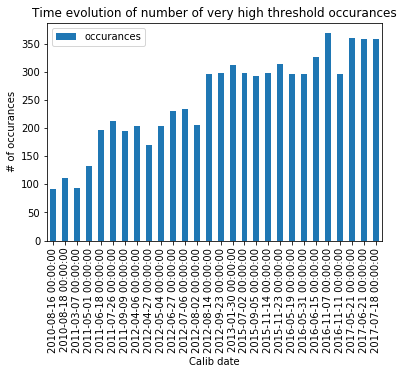

In [165]:
axe = chart2_df.groupby(['datetime']).sum().plot(y='occurances',kind='bar')
axe.set_title('Time evolution of number of very high threshold occurances')
axe.set_xlabel('Calib date')
axe.set_ylabel('# of occurances')

In [238]:
chart3_df = chart2_df[chart2_df.occurances != 0]

In [239]:
x = chart3_df.datetime
labels = chart3_df['sensor_number'].unique()
todf = {k:[] for k in labels}
yx = []
for date in x:
    for label in labels:
        data_ = chart3_df[chart3_df.datetime==date]
        val = data_[data_.sensor_number==label].occurances.values
        if not val:
            val = 0
        else:
            val = val[0]
        todf[label].append(val)
occurances_df3 = pd.DataFrame(todf,index=x.values)
occurances_df3 = occurances_df3.sort_index()

In [242]:
occurances_df3 = occurances_df3.drop_duplicates()

In [243]:
run1 = occurances_df3[occurances_df3.index <= '2013-01-30']

In [244]:
run2 = occurances_df3[occurances_df3.index > '2013-01-30']

In [245]:
run1 = run1.drop(run1.columns[run1.sum()==0],axis=1)

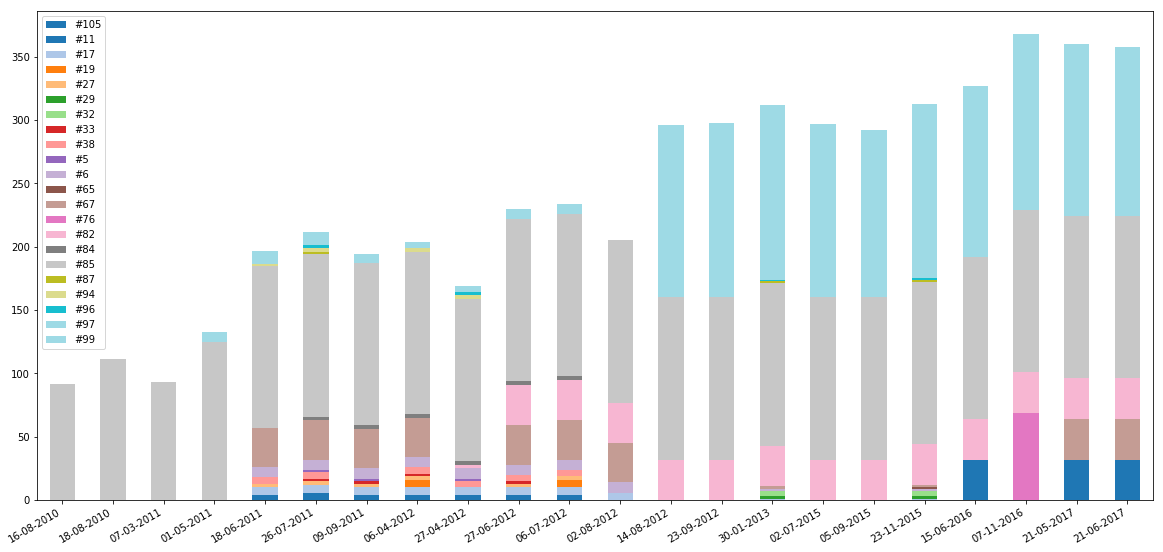

In [250]:
fig, axe = plt.subplots(1,1,figsize=(20,10))
occurances_df3.plot(kind='bar', ax=axe,align="center", stacked=True, colormap='tab20')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(occurances_df3.index.to_series().dt.strftime("%d-%m-%Y")))
fig.autofmt_xdate()

In [327]:
dataplot = occurances_df3.copy()


In [328]:
for sensor,column in occurances_df3.iteritems():
    dataplot[sensor][column!=0]=int(sensor[1:])
dataplot = dataplot.transpose()

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


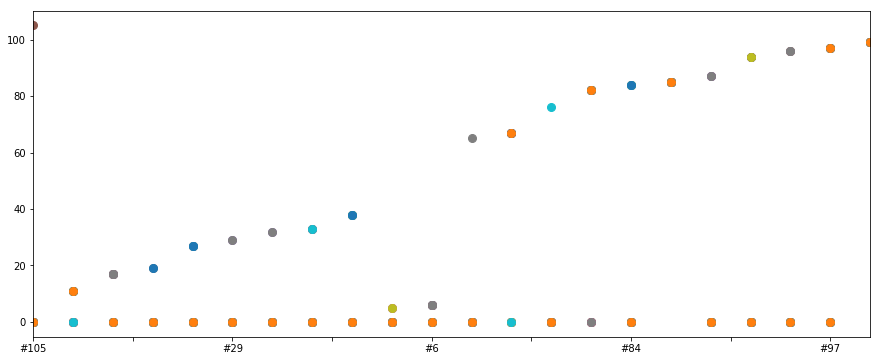

In [326]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
for sensor in dataplot:
    ax = dataplot[sensor].plot(linestyle='',marker='o', ax=ax, markersize=8)

In [278]:
dataplot.plot(y=dataplot.index,x=dataplot.columns,marker='.',linestyle='')

KeyError: "DatetimeIndex(['2010-08-16', '2010-08-18', '2011-03-07', '2011-05-01',\n               '2011-06-18', '2011-07-26', '2011-09-09', '2012-04-06',\n               '2012-04-27', '2012-06-27', '2012-07-06', '2012-08-02',\n               '2012-08-14', '2012-09-23', '2013-01-30', '2015-07-02',\n               '2015-09-05', '2015-11-23', '2016-06-15', '2016-11-07',\n               '2017-05-21', '2017-06-21'],\n              dtype='datetime64[ns]', freq=None) not in index"

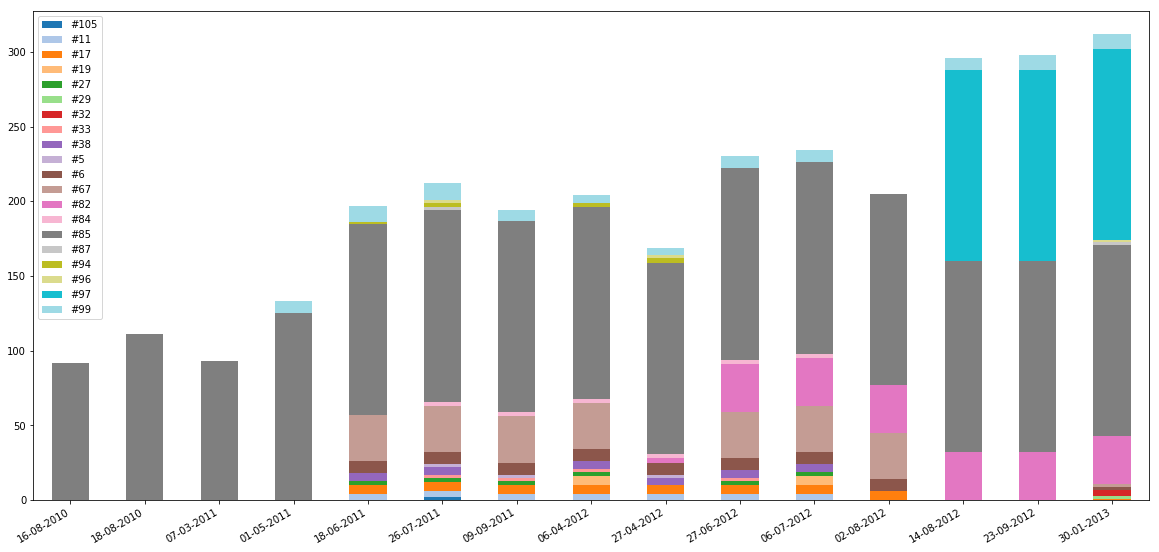

In [246]:
fig, axe = plt.subplots(1,1,figsize=(20,10))
run1.plot(kind='bar', ax=axe,align="center", stacked=True, colormap='tab20')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(run1.index.to_series().dt.strftime("%d-%m-%Y")))
fig.autofmt_xdate()

In [247]:
run2

#105  #11  #17  #19  #27  #29  #32  #33  #38  #5 ...   #67  #76  \
2015-07-02     0    0    0    0    0    0    0    0    0   0 ...     0    0   
2015-09-05     0    0    0    0    0    0    0    0    0   0 ...     0    0   
2015-11-23     0    0    1    0    0    2    4    0    0   0 ...     2    0   
2016-06-15     0   32    0    0    0    0    0    0    0   0 ...     0    0   
2016-11-07     0    0    0    0    0    0    0    0    0   0 ...     0   69   
2017-05-21     0   32    0    0    0    0    0    0    0   0 ...    32    0   
2017-06-21     0   32    0    0    0    0    0    0    0   0 ...    32    0   

            #82  #84  #85  #87  #94  #96  #97  #99  
2015-07-02   32    0  128    0    0    0  128    9  
2015-09-05   32    0  128    0    0    0  128    4  
2015-11-23   32    0  128    2    0    1  128   10  
2016-06-15   32    0  128    0    0    0  128    7  
2016-11-07   32    0  128    0    0    0  128   11  
2017-05-21   32    0  128    0    0    0  128    8  
2017-06-21   32    0  128    0    0    0  128    6  

[7 rows x 22 columns]

In [248]:
run2 = run2.drop(run2.columns[run2.sum()==0],axis=1)

In [249]:
fig, axe = plt.subplots(1,1,figsize=(20,10))
run2.plot(kind='bar', ax=axe,align="center", stacked=True, colormap='tab20')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(run2.index.to_series().dt.strftime("%d-%m-%Y")))
fig.autofmt_xdate()

Text(0,0.5,'# of occurances')

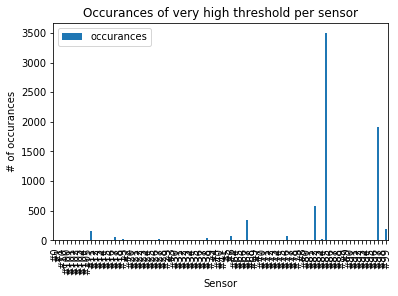

In [68]:
axe = chart2_df.groupby(['sensor_number']).sum().plot(y='occurances', kind='bar')
axe.set_title('Occurances of very high threshold per sensor')
axe.set_xlabel('Sensor')
axe.set_ylabel('# of occurances')

In [155]:
groupbysensor= chart2_df.groupby(['sensor_number','sensor_type']).sum()

In [152]:
axe = groupbysensor[groupbysensor.occurances!=0].plot(y='occurances',kind='bar')
axe.set_title('Occurances of very high threshold per sensor')
axe.set_xlabel('Sensor')
axe.set_ylabel('# of occurances')

Text(0,0.5,'# of occurances')

In [157]:
groupbysensor[groupbysensor.occurances!=0]

Zmod  occurances
sensor_number sensor_type                   
#105          phi          21000           2
#11           R             -280         160
#17           R             2240          56
#19           R             3080          18
#27           R             6440          21
#29           R             7280           4
#32           R            12180           8
#33           R            12600          10
#38           R            19180          35
#5            R            -2800           6
#6            R            -2380          76
#65           phi          -4480           1
#67           phi          -3640         348
#76           phi            140          69
#82           phi           2660         579
#84           phi           3500          21
#85           phi           3920        3493
#87           phi           4760           6
#94           phi           7700          13
#96           phi          12180           6
#97           phi          12600        1920
#99           phi          16800         191

# Other weird thing found with trending

In [37]:
occurance_per_row = filtered.sum(axis=1)

In [38]:
chart1_df = other.df.drop(other.df.iloc[:,9:].columns , axis=1)

In [39]:
chart1_df['occurances'] = occurance_per_row

In [40]:
axe = chart1_df.groupby(['datetime']).sum().plot(y='occurances',kind='bar')
axe.set_title('Time evolution of number of very high threshold occurances')
axe.set_xlabel('Calib date')
axe.set_ylabel('# of occurances')

Text(0,0.5,'# of occurances')

Text(0,0.5,'# of occurances')

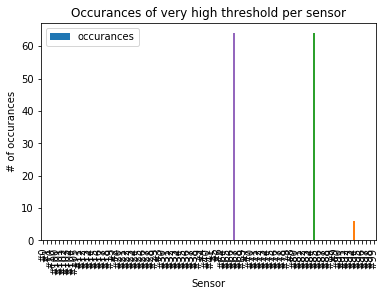

In [41]:
axe = chart1_df.groupby(['sensor_number']).sum().plot(y='occurances', kind='bar')
axe.set_title('Occurances of very high threshold per sensor')
axe.set_xlabel('Sensor')
axe.set_ylabel('# of occurances')

In [42]:
data = other["#6"].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[5,30]])
axe.set_title('Sensor #85, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Text(0,0.5,'ADC')

In [43]:
other["#6"][(other["#6"].df.iloc[:,913:914]>=14.).sum(axis=1)!=0]

type sensor   datetime  Zmod slot_label mod_nr mod_type  \
548  hit_threshold      6 2011-03-07   -85      VL04L  mod_6   VELO_R   
584  hit_threshold      6 2012-08-02   -85      VL04L  mod_6   VELO_R   

    sensor_type sensor_number  channel0     ...       channel2038  \
548           R            #6      24.0     ...              13.0   
584           R            #6      22.0     ...              16.0   

     channel2039  channel2040  channel2041  channel2042  channel2043  \
548         13.0         13.0         13.0         13.0         13.0   
584         16.0         16.0         17.0         17.0         16.0   

     channel2044  channel2045  channel2046  channel2047  
548         13.0         13.0         13.0         13.0  
584         17.0         16.0         17.0         22.0  

[2 rows x 2057 columns]

../src\dataset.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.df[item]


Text(0,0.5,'ADC')

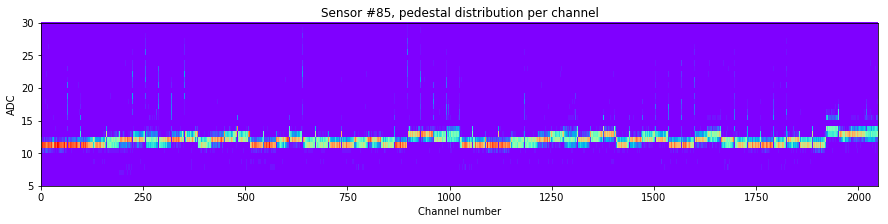

In [44]:
data = other["R"][other.df['datetime']=="2011-03-07"].iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[5,30]])
axe.set_title('Sensor #85, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

In [45]:
data = other["phi"][other.df['datetime']=="2011-03-07"].iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[5,30]])
axe.set_title('Sensor #85, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

../src\dataset.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.df[item]


Text(0,0.5,'ADC')

../src\dataset.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.df[item]


Text(0,0.5,'ADC')

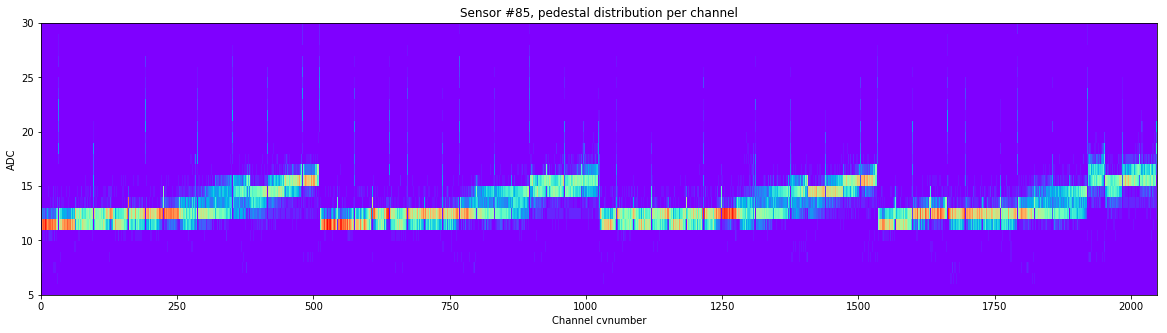

In [46]:
data = other["R"][other.df['datetime']=="2012-08-02"].iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(20,5))
_ = plt.hist2d(px, py, bins=[2048,25], range=[[0,2048],[5,30]])
axe.set_title('Sensor #85, pedestal distribution per channel')
axe.set_xlabel('Channel cvnumber')
axe.set_ylabel('ADC')

../src\dataset.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.df[item]


Text(0,0.5,'ADC')

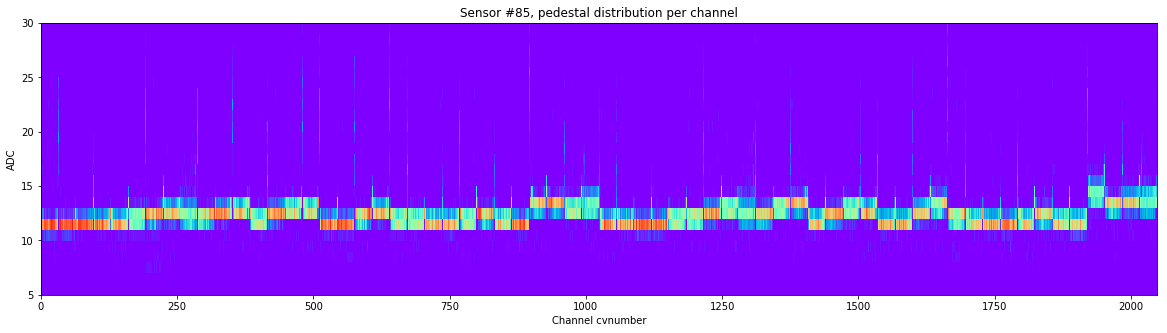

In [219]:
data = other["R"][other.df['datetime']=="2011-03-07"].iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(20,5))
_ = plt.hist2d(px, py, bins=[2048,25], range=[[0,2048],[5,30]])
axe.set_title('Sensor #85, pedestal distribution per channel')
axe.set_xlabel('Channel cvnumber')
axe.set_ylabel('ADC')

In [160]:
data.mean().mean()

12.8777553013393

../src\dataset.py:108: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.df[item]


Text(0,0.5,'ADC')

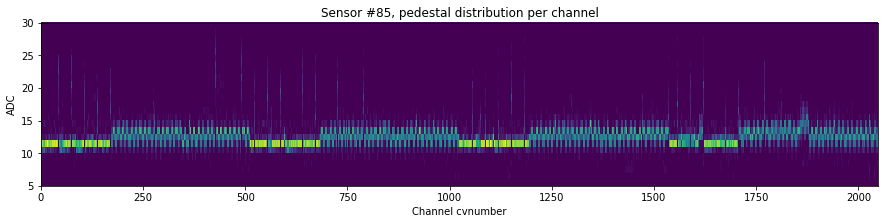

In [134]:
data = other["phi"][other.df['datetime']=="2012-08-02"].iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,25], range=[[0,2048],[5,30]])
axe.set_title('Sensor #85, pedestal distribution per channel')
axe.set_xlabel('Channel cvnumber')
axe.set_ylabel('ADC')

In [133]:
(data==16.).sum().sum()

563